In [1]:
# Cell 1: Install dependencies
# Uncomment and run the following command if dependencies are not already installed.
# %pip install scikit-learn scikit-image SimpleITK nibabel nilearn albumentations seaborn pandas numpy matplotlib tqdm pydicom scipy


In [15]:
# Cell 2: Import statements and environment setup
import torch

def configure_gpu():
    """
    Configures GPU settings:
    - Detects CUDA device
    - Enables CUDNN benchmarking for improved performance on NVIDIA 4070Ti
    """
    if torch.cuda.is_available():
        device = torch.device("cuda")
        # Enable CUDNN benchmark for optimized convolution algorithm selection
        torch.backends.cudnn.benchmark = True
        print(f"Using GPU: {torch.cuda.get_device_name(device)}")
    else:
        raise EnvironmentError("CUDA-compatible GPU not found. Please check your GPU configuration.")

def print_gpu_memory_stats():
    """
    Prints current GPU memory usage for monitoring.
    """
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / (1024 ** 2)
        reserved = torch.cuda.memory_reserved() / (1024 ** 2)
        print(f"GPU Memory Allocated: {allocated:.2f} MB")
        print(f"GPU Memory Reserved: {reserved:.2f} MB")
    else:
        print("CUDA not available.")

# Configure GPU on startup
configure_gpu()
print_gpu_memory_stats()

import warnings
warnings.filterwarnings('ignore')

Using GPU: NVIDIA GeForce RTX 4070 Ti
GPU Memory Allocated: 0.00 MB
GPU Memory Reserved: 0.00 MB


In [3]:
# Cell 3: GPU Setup and Memory Management
import os
import logging
import warnings
import pandas as pd

# Configure logging for quality assurance (logs will be written to data_ingestion.log)
logging.basicConfig(level=logging.INFO, filename="data_ingestion.log", filemode="w",
                    format="%(asctime)s - %(levelname)s - %(message)s")

def collect_files(base_dir):
    """
    Recursively collects DICOM files only from the expected folders:
    - PPMI_Images_PD: Label "PD"
    - PPMI_Images_SWEDD: Label "SWEDD"
    - PPMI_Images_Cont: Label "Control"
    
    Excludes any file containing "br_raw" in its path and logs all skipped folders.
    
    :param base_dir: Base directory containing the Images folder.
    :return: (included_files, excluded_files)
             included_files: list of tuples (full_path, label)
             excluded_files: list of file paths that were excluded.
    """
    included_files = []
    excluded_files = []
    
    # Define the expected folders and corresponding labels
    expected_folders = {
        "PPMI_Images_PD": "PD",
        "PPMI_Images_SWEDD": "SWEDD",
        "PPMI_Images_Cont": "Control"
    }
    
    # Iterate over immediate subdirectories in base_dir
    for folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder)
        if os.path.isdir(folder_path) and folder in expected_folders:
            logging.info(f"Processing folder: {folder_path}")
            # Recursively traverse the expected folder
            for root, dirs, files in os.walk(folder_path):
                for file in files:
                    if file.endswith(".dcm"):
                        full_path = os.path.join(root, file)
                        # Exclude any file with "br_raw" in its full path
                        if "br_raw" in full_path:
                            excluded_files.append(full_path)
                            logging.info(f"Excluding raw file: {full_path}")
                        else:
                            included_files.append((full_path, expected_folders[folder]))
        else:
            logging.info(f"Skipping folder: {folder_path}")
    
    return included_files, excluded_files

def generate_dataframe(included_files):
    """
    Creates a DataFrame from the list of validated file paths.
    
    :param included_files: List of tuples (file_path, label)
    :return: DataFrame with columns 'file_path' and 'label'
    """
    df = pd.DataFrame(included_files, columns=["file_path", "label"])
    return df

def save_qa_report(total_files, included_count, excluded_count, output_path="data_ingestion_QA_report.csv"):
    """
    Generates and saves a QA report of the file collection process.
    
    :param total_files: Total number of DICOM files encountered.
    :param included_count: Count of files included after filtering.
    :param excluded_count: Count of files excluded.
    :param output_path: File path for the QA report CSV.
    """
    exclusion_ratio = excluded_count / total_files if total_files > 0 else 0
    qa_report = {
        "total_files": total_files,
        "included_files": included_count,
        "excluded_files": excluded_count,
        "exclusion_ratio": exclusion_ratio,
    }
    qa_df = pd.DataFrame([qa_report])
    qa_df.to_csv(output_path, index=False)
    logging.info("QA report saved to %s", output_path)
    
    if exclusion_ratio > 0.5:
        warnings.warn(f"High proportion of raw files excluded: {exclusion_ratio:.2%}")


In [4]:
# Cell 4: Data Ingestion Pipeline
import pydicom
import numpy as np

def load_dicom(file_path):
    """
    Loads and processes a DICOM file:
    - Reads the file using pydicom.
    - Converts the pixel array to float32.
    - Applies RescaleSlope and RescaleIntercept if available.
    
    :param file_path: Path to the DICOM file.
    :return: Tuple (processed_pixel_array, dicom_metadata)
    """
    try:
        ds = pydicom.dcmread(file_path)
    except Exception as e:
        raise IOError(f"Error reading DICOM file {file_path}: {e}")
    
    # Extract pixel array and convert to float32
    pixel_array = ds.pixel_array.astype(np.float32)
    
    # Apply rescaling if attributes are present
    if hasattr(ds, 'RescaleSlope') and hasattr(ds, 'RescaleIntercept'):
        slope = ds.RescaleSlope
        intercept = ds.RescaleIntercept
        pixel_array = pixel_array * slope + intercept
    
    return pixel_array, ds

In [5]:
# Cell 5: Execute Data Ingestion Pipeline
# Define the base directory containing the "Images" folder (adjust if necessary)
base_dir = "Images"

# Collect files from only the expected subdirectories
included_files, excluded_files = collect_files(base_dir)

# Create a DataFrame for the validated file paths and their labels
df = generate_dataframe(included_files)

# Final validation: Ensure that no "br_raw" files are included
if df["file_path"].str.contains("br_raw").any():
    raise ValueError("Validation failed: 'br_raw' files detected in the final dataset!")

# Save the validated file paths to CSV for reproducibility
df.to_csv("validated_file_paths.csv", index=False)
print("Validated file paths saved to validated_file_paths.csv")

# Generate and save the QA report
total_files = len(included_files) + len(excluded_files)
save_qa_report(total_files, len(included_files), len(excluded_files))
print("QA report generated and saved as data_ingestion_QA_report.csv")

Validated file paths saved to validated_file_paths.csv
QA report generated and saved as data_ingestion_QA_report.csv


Loading file for group PD: Images\PPMI_Images_PD\50028\Reconstructed_DaTSCAN\2016-07-27_13_35_28.0\I846807\PPMI_50028_NM_Reconstructed_DaTSCAN_Br_20170503120948515_1_S561053_I846807.dcm
Loading file for group SWEDD: Images\PPMI_Images_SWEDD\3550\Reconstructed_DaTSCAN\2010-10-14_16_13_23.0\I339549\PPMI_3550_NM_Reconstructed_DaTSCAN_Br_20121011134749064_1_S117647_I339549.dcm
Loading file for group Control: Images\PPMI_Images_Cont\3270\Reconstructed_DaTSCAN\2011-09-01_14_23_06.0\I341074\PPMI_3270_NM_Reconstructed_DaTSCAN_Br_20121018134659840_1_S124326_I341074.dcm


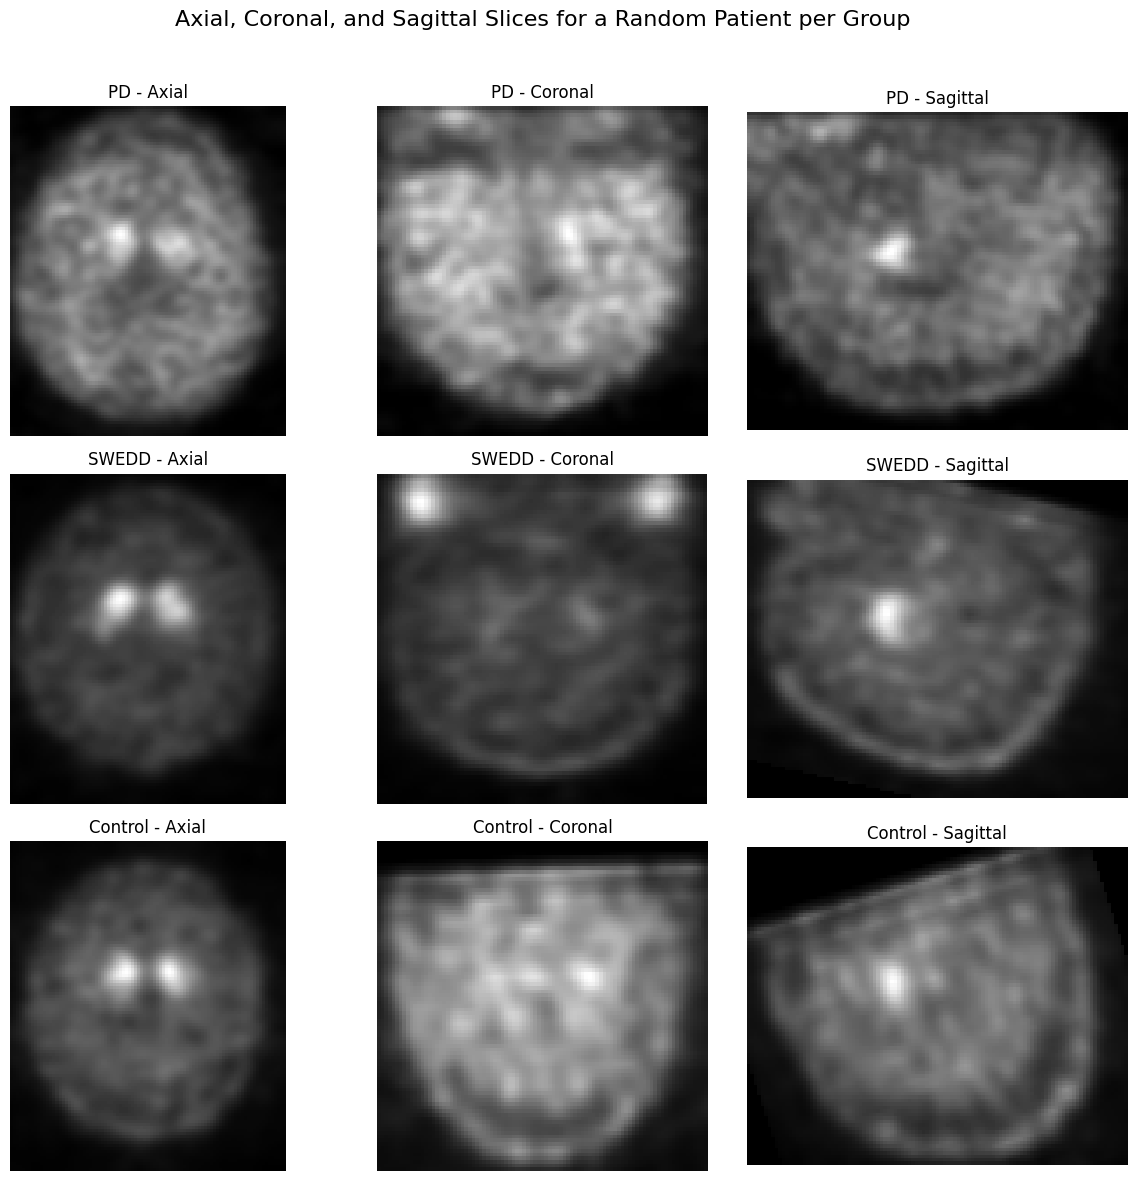

In [6]:
# Cell 6: Visualize One Axial, Coronal, and Sagittal Slice for a Random Patient per Group

import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np

# Read the validated file paths CSV generated earlier
df = pd.read_csv("validated_file_paths.csv")

# Function to extract the three orthogonal slices from a 3D volume
def extract_slices(volume):
    """
    Given a 3D volume, returns one axial, one coronal, and one sagittal slice.
    Assumes volume shape is (depth, height, width).
    """
    d, h, w = volume.shape
    axial = volume[d // 2, :, :]         # Axial: slice along depth
    coronal = volume[:, h // 2, :]        # Coronal: slice along height
    sagittal = volume[:, :, w // 2]       # Sagittal: slice along width
    return axial, coronal, sagittal

# List of groups and their expected labels
groups = {"PD": "PD", "SWEDD": "SWEDD", "Control": "Control"}

# Create a figure with one row per group and three columns for the views
fig, axes = plt.subplots(nrows=len(groups), ncols=3, figsize=(12, 4 * len(groups)))
fig.suptitle("Axial, Coronal, and Sagittal Slices for a Random Patient per Group", fontsize=16)

for i, (group_key, group_label) in enumerate(groups.items()):
    # Filter DataFrame for the current group
    group_df = df[df["label"] == group_label]
    if group_df.empty:
        print(f"No data found for group {group_label}")
        continue
    
    # Select a random file from the group
    random_file = group_df.sample(1)["file_path"].values[0]
    print(f"Loading file for group {group_label}: {random_file}")
    
    # Load the DICOM volume using the previously defined load_dicom() function
    volume, _ = load_dicom(random_file)
    
    # Verify the volume is 3D (if not, skip or raise an error)
    if volume.ndim != 3:
        raise ValueError(f"Expected 3D volume, got shape {volume.shape} for file: {random_file}")
    
    axial, coronal, sagittal = extract_slices(volume)
    
    # Plot Axial slice
    ax = axes[i, 0]
    ax.imshow(axial, cmap="gray")
    ax.set_title(f"{group_label} - Axial")
    ax.axis("off")
    
    # Plot Coronal slice
    ax = axes[i, 1]
    ax.imshow(coronal, cmap="gray")
    ax.set_title(f"{group_label} - Coronal")
    ax.axis("off")
    
    # Plot Sagittal slice
    ax = axes[i, 2]
    ax.imshow(sagittal, cmap="gray")
    ax.set_title(f"{group_label} - Sagittal")
    ax.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [7]:
# Cell 7: Data Preprocessing – Intensity Normalization & Volume Processing

import numpy as np

def intensity_normalization(volume):
    """
    Normalizes intensity values:
    - Truncates negative values (sets them to 0)
    - Applies min-max scaling to bring values between 0 and 1 per volume.
    
    :param volume: Input 3D volume as a numpy array.
    :return: Normalized volume.
    """
    volume = np.clip(volume, a_min=0, a_max=None)
    vol_min, vol_max = volume.min(), volume.max()
    if vol_max > vol_min:
        volume = (volume - vol_min) / (vol_max - vol_min)
    else:
        volume = volume - vol_min  # volume is constant
    return volume

def resize_volume(volume, target_shape=(128, 128, 128)):
    """
    Resizes the volume to the target shape using zero-padding or center cropping while preserving aspect ratio.
    
    :param volume: Input 3D volume (numpy array) with shape (d, h, w).
    :param target_shape: Desired output shape (d_out, h_out, w_out).
    :return: Resized volume with shape target_shape.
    """
    current_shape = volume.shape
    resized = volume.copy()
    
    # For each dimension, either pad or crop to the target size
    for i in range(3):
        current = resized.shape[i]
        target = target_shape[i]
        if current < target:
            # Calculate padding sizes
            pad_total = target - current
            pad_before = pad_total // 2
            pad_after = pad_total - pad_before
            pad_width = [(0, 0), (0, 0), (0, 0)]
            pad_width[i] = (pad_before, pad_after)
            resized = np.pad(resized, pad_width=pad_width, mode="constant", constant_values=0)
        elif current > target:
            # Center crop
            start = (current - target) // 2
            end = start + target
            if i == 0:
                resized = resized[start:end, :, :]
            elif i == 1:
                resized = resized[:, start:end, :]
            elif i == 2:
                resized = resized[:, :, start:end]
    return resized

# Example usage (for testing on one volume):
volume, _ = load_dicom(random_file)  # random_file selected previously
norm_vol = intensity_normalization(volume)
resized_vol = resize_volume(norm_vol)
print("Original shape:", volume.shape, "Resized shape:", resized_vol.shape)

Original shape: (91, 109, 91) Resized shape: (128, 128, 128)


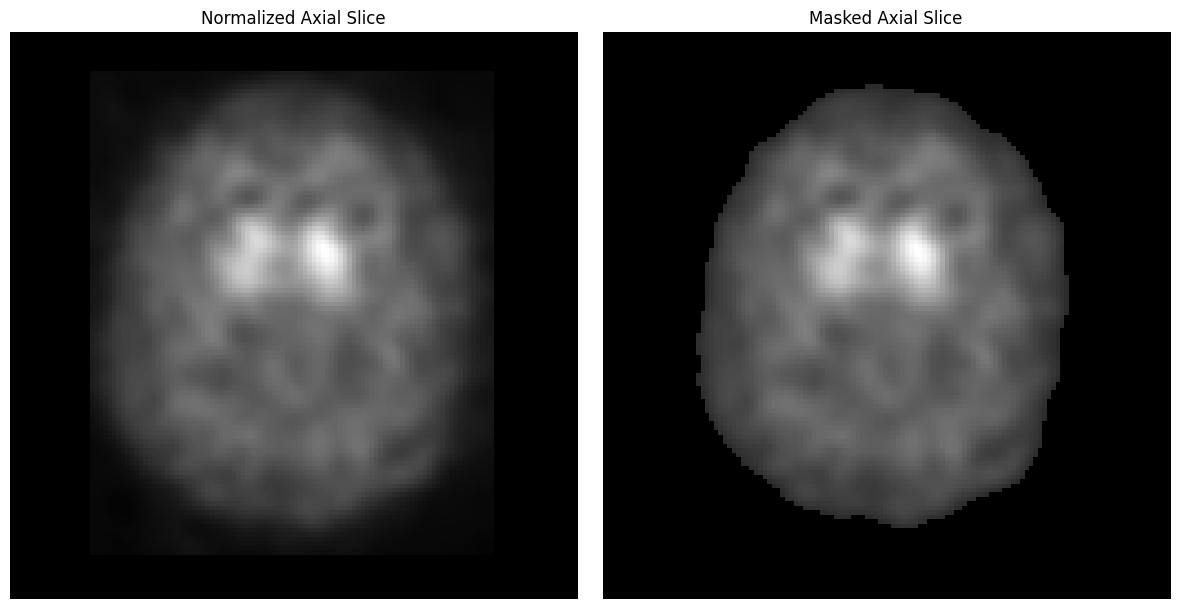

In [8]:
# Cell 8: Data Preprocessing – Brain Masking

import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from skimage.morphology import binary_closing, ball

# If not already defined, include the resize_volume function:
def resize_volume(volume, target_shape=(128, 128, 128)):
    """
    Resizes the volume to the target shape using zero-padding or center cropping.
    
    :param volume: Input 3D volume as a numpy array.
    :param target_shape: Desired output shape (depth, height, width).
    :return: Resized volume.
    """
    resized = volume.copy()
    for i in range(3):
        current = resized.shape[i]
        target = target_shape[i]
        if current < target:
            pad_total = target - current
            pad_before = pad_total // 2
            pad_after = pad_total - pad_before
            pad_width = [(0, 0), (0, 0), (0, 0)]
            pad_width[i] = (pad_before, pad_after)
            resized = np.pad(resized, pad_width=pad_width, mode="constant", constant_values=0)
        elif current > target:
            start = (current - target) // 2
            end = start + target
            if i == 0:
                resized = resized[start:end, :, :]
            elif i == 1:
                resized = resized[:, start:end, :]
            elif i == 2:
                resized = resized[:, :, start:end]
    return resized

def process_volume(volume, target_shape=(128, 128, 128)):
    """
    Process a 3D volume by:
    1. Normalizing intensity (truncating negatives and min-max scaling).
    2. Resizing to target_shape.
    3. Generating a brain mask via Otsu thresholding and 3D morphological closing.
    
    Returns:
      - norm_vol: The normalized and resized volume.
      - mask: The computed brain mask.
      - masked_vol: norm_vol multiplied by mask (i.e. non-brain regions zeroed out).
    """
    # 1. Intensity normalization (truncate negatives and min-max scale)
    volume = np.clip(volume, a_min=0, a_max=None)
    vmin, vmax = volume.min(), volume.max()
    if vmax > vmin:
        norm_vol = (volume - vmin) / (vmax - vmin)
    else:
        norm_vol = volume - vmin

    # 2. Resize the normalized volume to the target shape
    norm_vol = resize_volume(norm_vol, target_shape=target_shape)

    # 3. Compute brain mask using Otsu threshold and binary closing
    thresh = threshold_otsu(norm_vol)
    mask = norm_vol > thresh
    mask = binary_closing(mask, footprint=ball(2))  # using "footprint" as per current API
    masked_vol = norm_vol * mask

    return norm_vol, mask, masked_vol

# Demonstration: Load one sample DICOM file (using the first file in your validated DataFrame)
sample_file = df.iloc[0]["file_path"]
original_volume, _ = load_dicom(sample_file)

# Process the volume with our new function
norm_vol, mask, masked_vol = process_volume(original_volume, target_shape=(128,128,128))

# Extract an axial (middle) slice from both the normalized volume and the masked volume
axial_norm = norm_vol[norm_vol.shape[0]//2, :, :]
axial_masked = masked_vol[masked_vol.shape[0]//2, :, :]

# Plot side-by-side for comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(axial_norm, cmap="gray")
axes[0].set_title("Normalized Axial Slice")
axes[0].axis("off")

axes[1].imshow(axial_masked, cmap="gray")
axes[1].set_title("Masked Axial Slice")
axes[1].axis("off")

plt.tight_layout()
plt.show()


In [9]:
# Cell 9: Simplified version with better error tracking
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import gc
import numpy as np
import os
import psutil

class DaTScanDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform
        self._calculate_dataset_statistics()
    
    def _calculate_dataset_statistics(self):
        """Calculate dataset statistics"""
        print("Calculating dataset statistics...")
        chunk_size = 10
        for i in tqdm(range(0, len(self.df), chunk_size), desc="Computing stats"):
            chunk = self.df.iloc[i:min(i+chunk_size, len(self.df))]
            for _, row in chunk.iterrows():
                try:
                    volume, _ = load_dicom(row["file_path"])
                    if not hasattr(self, 'stats'):
                        self.stats = {'min': volume.min(), 'max': volume.max()}
                    else:
                        self.stats['min'] = min(self.stats['min'], volume.min())
                        self.stats['max'] = max(self.stats['max'], volume.max())
                    del volume
                    gc.collect()
                except Exception as e:
                    print(f"Error processing file {row['file_path']}: {e}")
        print(f"Dataset statistics: min={self.stats['min']}, max={self.stats['max']}")
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        try:
            file_path = self.df.iloc[idx]["file_path"]
            print(f"Loading file {idx}: {file_path}")  # Debug print
            
            # Load and process DICOM
            volume, _ = load_dicom(file_path)
            print(f"DICOM loaded, shape: {volume.shape}")  # Debug print
            
            norm_vol, mask, masked_vol = process_volume(volume, target_shape=(128, 128, 128))
            print(f"Volume processed, shape: {masked_vol.shape}")  # Debug print
            
            # Clean up original data
            del volume, norm_vol, mask
            gc.collect()
            
            # Convert to tensor
            volume_tensor = torch.from_numpy(np.expand_dims(masked_vol, axis=0)).float()
            print(f"Tensor created, shape: {volume_tensor.shape}")  # Debug print
            
            del masked_vol
            gc.collect()
            
            return {
                "volume": volume_tensor,
                "label": self.df.iloc[idx]["label"],
                "path": file_path
            }
            
        except Exception as e:
            print(f"Error loading file {file_path}: {str(e)}")
            import traceback
            traceback.print_exc()
            return None

def create_dataloaders(df, batch_size=2, train_split=0.8):
    """Create train and validation dataloaders"""
    # Split dataset
    train_size = int(len(df) * train_split)
    train_df = df.iloc[:train_size]
    val_df = df.iloc[train_size:]
    
    # Create datasets
    train_dataset = DaTScanDataset(train_df)
    val_dataset = DaTScanDataset(val_df)
    
    # Create simple dataloaders without multiprocessing
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,  # No multiprocessing
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,  # No multiprocessing
        pin_memory=True
    )
    
    return train_loader, val_loader

def print_memory_stats():
    """Print memory usage statistics"""
    if torch.cuda.is_available():
        print("\nGPU Memory Usage:")
        print(f"Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
        print(f"Cached: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")
    print(f"CPU Memory Usage: {psutil.Process().memory_info().rss / 1024**2:.2f} MB")

# Create and test dataloaders
print("Creating dataloaders...")
train_loader, val_loader = create_dataloaders(df, batch_size=2)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

# Test the first few batches with detailed logging
print("\nTesting first few batches from training loader...")
print_memory_stats()

try:
    for i, batch in enumerate(tqdm(train_loader, desc="Processing batches")):
        print(f"\nProcessing batch {i+1}")
        
        if batch is not None:
            print(f"Batch shapes: {batch['volume'].shape}")
            print(f"Labels: {batch['label']}")
            print_memory_stats()
        else:
            print(f"Batch {i+1} is None!")
        
        gc.collect()
        torch.cuda.empty_cache()
        
        if i >= 4:  # Test first 5 batches
            break
            
except Exception as e:
    print(f"Error during batch processing: {str(e)}")
    import traceback
    traceback.print_exc()

Creating dataloaders...
Calculating dataset statistics...


Computing stats:   0%|          | 0/239 [00:00<?, ?it/s]

Dataset statistics: min=-32768.0, max=32767.0
Calculating dataset statistics...


Computing stats:   0%|          | 0/60 [00:00<?, ?it/s]

Dataset statistics: min=-32768.0, max=32767.0
Number of training batches: 1194
Number of validation batches: 299

Testing first few batches from training loader...

GPU Memory Usage:
Allocated: 0.00 MB
Cached: 0.00 MB
CPU Memory Usage: 565.38 MB


Processing batches:   0%|          | 0/1194 [00:00<?, ?it/s]

Loading file 82: Images\PPMI_Images_Cont\3000\Reconstructed_DaTSCAN\2011-01-20_16_28_47.0\I323662\PPMI_3000_NM_Reconstructed_DaTSCAN_Br_20120814154829508_1_S117534_I323662.dcm
DICOM loaded, shape: (91, 109, 91)
Volume processed, shape: (128, 128, 128)
Tensor created, shape: torch.Size([1, 128, 128, 128])
Loading file 1490: Images\PPMI_Images_PD\3373\Reconstructed_DaTSCAN\2014-07-30_15_24_37.0\I449019\PPMI_3373_NM_Reconstructed_DaTSCAN_Br_20141021160516605_1_S234165_I449019.dcm
DICOM loaded, shape: (91, 109, 91)
Volume processed, shape: (128, 128, 128)
Tensor created, shape: torch.Size([1, 128, 128, 128])

Processing batch 1
Batch shapes: torch.Size([2, 1, 128, 128, 128])
Labels: ['Control', 'PD']

GPU Memory Usage:
Allocated: 0.00 MB
Cached: 0.00 MB
CPU Memory Usage: 694.28 MB
Loading file 944: Images\PPMI_Images_PD\211547\Reconstructed_DaTSCAN\2023-01-13_16_23_04.0\I1671489\PPMI_211547_NM_Reconstructed_DaTSCAN_Br_20230228102249605_1_S1197959_I1671489.dcm
DICOM loaded, shape: (91, 109,

Creating stratified dataloaders...

Dataset split statistics:
Training set distribution:
label
PD         2043
Control     235
SWEDD       110
Name: count, dtype: int64

Validation set distribution:
label
PD         512
Control     59
SWEDD       27
Name: count, dtype: int64
Calculating dataset statistics...


Computing stats:   0%|          | 0/239 [00:00<?, ?it/s]

Dataset statistics: min=-32768.0, max=32767.0
Calculating dataset statistics...


Computing stats:   0%|          | 0/60 [00:00<?, ?it/s]

Dataset statistics: min=-32768.0, max=32767.0
Starting Exploratory Data Analysis...

Analyzing training dataset...
Analyzing dataset statistics...


Computing statistics:   0%|          | 0/1194 [00:00<?, ?it/s]

Loading file 286: Images\PPMI_Images_PD\41519\Reconstructed_DaTSCAN\2017-02-15_13_50_27.0\I846805\PPMI_41519_NM_Reconstructed_DaTSCAN_Br_20170503120842814_1_S561051_I846805.dcm
DICOM loaded, shape: (91, 109, 91)
Volume processed, shape: (128, 128, 128)
Tensor created, shape: torch.Size([1, 128, 128, 128])
Loading file 2019: Images\PPMI_Images_PD\3532\Reconstructed_DaTSCAN\2012-02-17_14_12_16.0\I341249\PPMI_3532_NM_Reconstructed_DaTSCAN_Br_20121019115838698_1_S146398_I341249.dcm
DICOM loaded, shape: (91, 109, 91)
Volume processed, shape: (128, 128, 128)
Tensor created, shape: torch.Size([1, 128, 128, 128])
Loading file 141: Images\PPMI_Images_PD\71189\Reconstructed_DaTSCAN\2019-10-11_15_27_55.0\I1317582\PPMI_71189_NM_Reconstructed_DaTSCAN_Br_20200616110608917_1_S941033_I1317582.dcm
DICOM loaded, shape: (91, 109, 91)
Volume processed, shape: (128, 128, 128)
Tensor created, shape: torch.Size([1, 128, 128, 128])
Loading file 741: Images\PPMI_Images_PD\4070\Reconstructed_DaTSCAN\2015-08-12_

C:\Users\alexc\AppData\Local\Temp\ipykernel_35056\1641169391.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=stats_df, x='label', y='mean', palette='viridis')
C:\Users\alexc\AppData\Local\Temp\ipykernel_35056\1641169391.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=stats_df, x='label', y='std', palette='viridis')


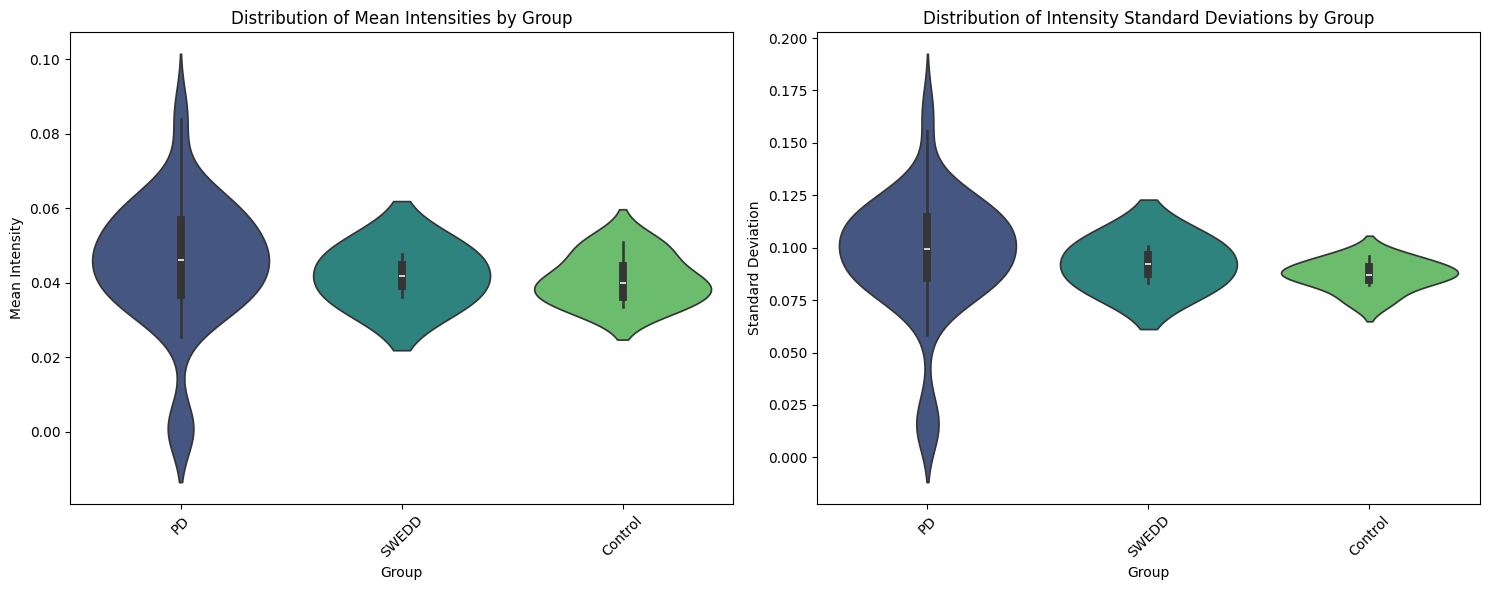


Plotting group statistics...


C:\Users\alexc\AppData\Local\Temp\ipykernel_35056\1641169391.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=stats_df, x='label', palette='viridis')
C:\Users\alexc\AppData\Local\Temp\ipykernel_35056\1641169391.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=stats_df, x='label', y='mean', palette='viridis')
C:\Users\alexc\AppData\Local\Temp\ipykernel_35056\1641169391.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=stats_df, x='label', y='std', palette='viridis')


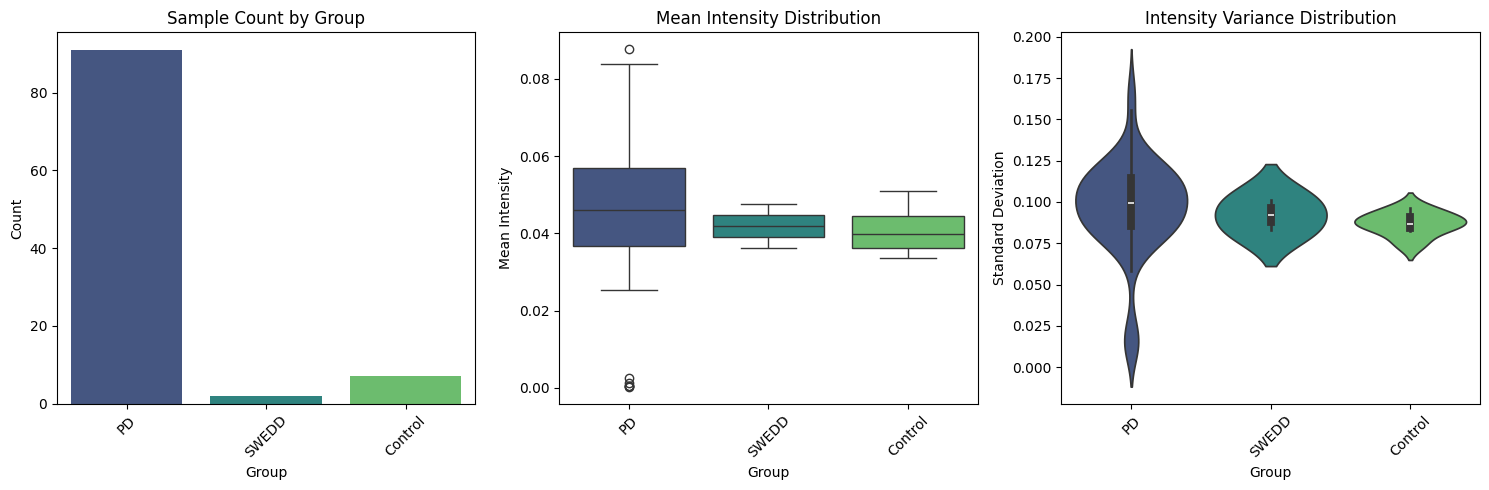


Analyzing spatial patterns...
Loading file 1210: Images\PPMI_Images_PD\4055\Reconstructed_DaTSCAN\2012-06-26_13_16_01.0\I343881\PPMI_4055_NM_Reconstructed_DaTSCAN_Br_20121105131759521_1_S159739_I343881.dcm
DICOM loaded, shape: (91, 109, 91)
Volume processed, shape: (128, 128, 128)
Tensor created, shape: torch.Size([1, 128, 128, 128])
Loading file 952: Images\PPMI_Images_PD\140722\Reconstructed_DaTSCAN\2022-02-02_14_02_09.0\I1548465\PPMI_140722_NM_Reconstructed_DaTSCAN_Br_20220224140332772_1_S1107919_I1548465.dcm
DICOM loaded, shape: (91, 109, 91)
Volume processed, shape: (128, 128, 128)
Tensor created, shape: torch.Size([1, 128, 128, 128])


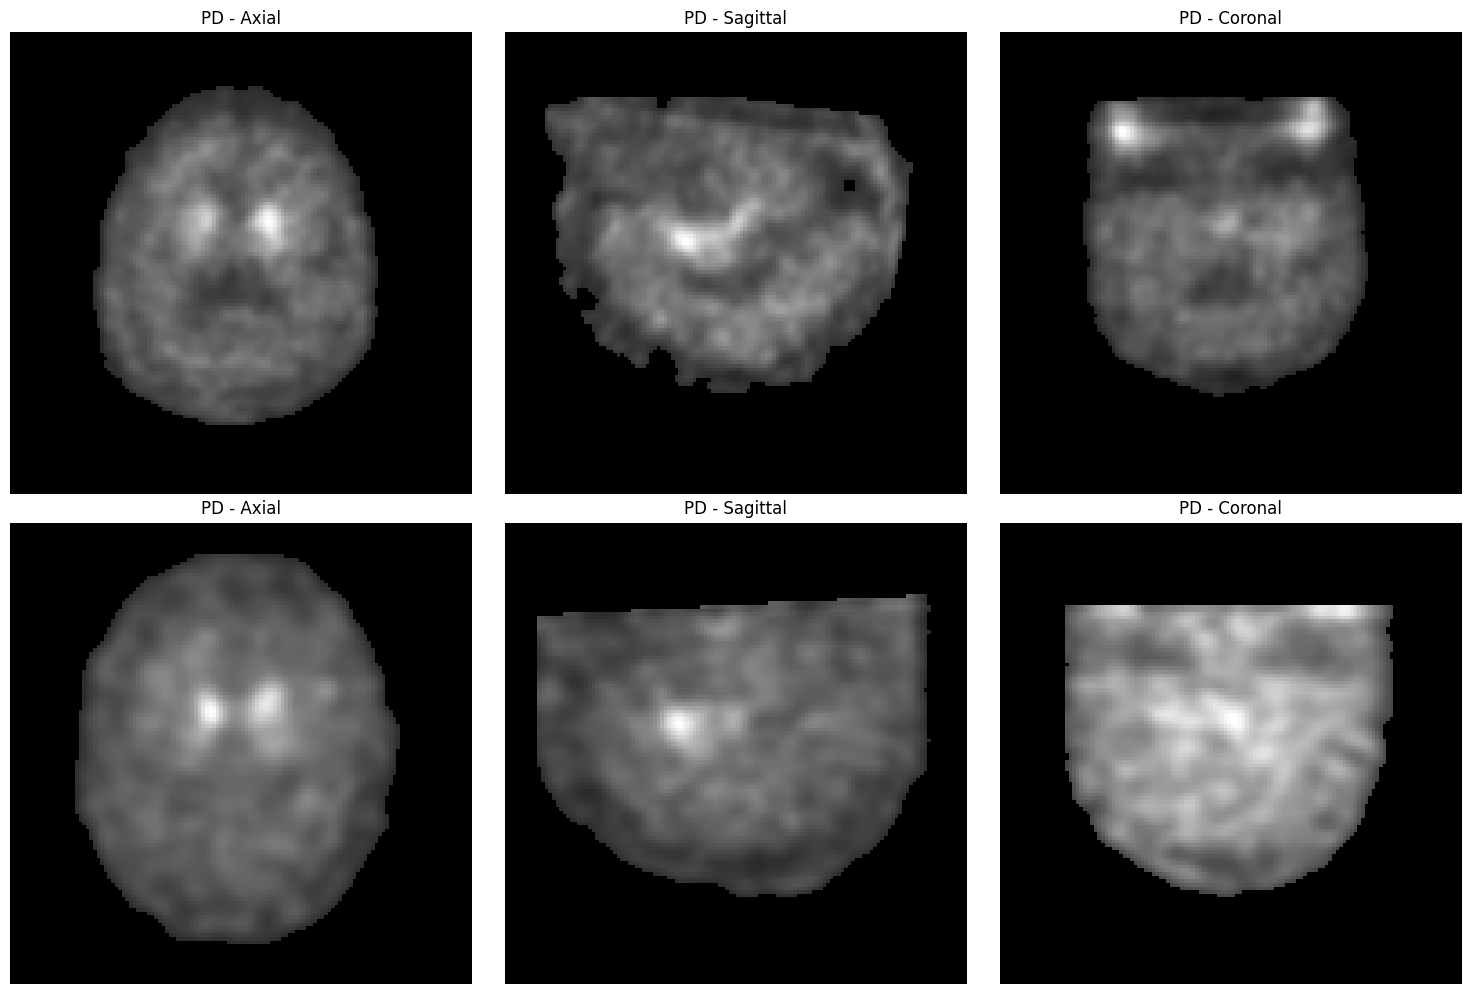


Summary Statistics by Group:
          mean           std        median       min       max     
          mean    std   mean    std   mean  std mean  std mean  std
label                                                              
Control  0.041  0.006  0.087  0.007    0.0  0.0  0.0  0.0  1.0  0.0
PD       0.045  0.017  0.097  0.029    0.0  0.0  0.0  0.0  1.0  0.0
SWEDD    0.042  0.008  0.092  0.013    0.0  0.0  0.0  0.0  1.0  0.0

EDA completed!


In [12]:
# Cell 10: Comprehensive EDA Implementation with Stratified Split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import defaultdict
from sklearn.model_selection import train_test_split

# First, let's implement proper stratified splitting
def create_stratified_dataloaders(df, batch_size=2, train_split=0.8):
    """
    Create train and validation dataloaders with stratified splitting to maintain class distributions
    """
    # Perform stratified split
    train_df, val_df = train_test_split(
        df, 
        test_size=1-train_split,
        stratify=df['label'],
        random_state=42
    )
    
    print("\nDataset split statistics:")
    print("Training set distribution:")
    print(train_df['label'].value_counts())
    print("\nValidation set distribution:")
    print(val_df['label'].value_counts())
    
    # Create datasets
    train_dataset = DaTScanDataset(train_df)
    val_dataset = DaTScanDataset(val_df)
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )
    
    return train_loader, val_loader

def analyze_dataset_statistics(dataloader, num_batches=None):
    """
    Analyzes dataset statistics with memory-efficient batch processing
    Returns: Dictionary of statistical measures
    """
    print("Analyzing dataset statistics...")
    stats = defaultdict(list)
    
    try:
        for i, batch in enumerate(tqdm(dataloader, desc="Computing statistics")):
            if num_batches and i >= num_batches:
                break
                
            volumes = batch['volume']
            labels = batch['label']
            
            # Per-volume statistics
            for vol_idx, (volume, label) in enumerate(zip(volumes, labels)):
                vol_data = volume.numpy().flatten()
                
                stats['mean'].append(np.mean(vol_data))
                stats['std'].append(np.std(vol_data))
                stats['median'].append(np.median(vol_data))
                stats['min'].append(np.min(vol_data))
                stats['max'].append(np.max(vol_data))
                stats['label'].append(label)
                
            # Memory cleanup
            del volumes, labels
            gc.collect()
            torch.cuda.empty_cache()
            
    except Exception as e:
        print(f"Error during statistical analysis: {str(e)}")
        import traceback
        traceback.print_exc()
    
    return pd.DataFrame(stats)

def plot_intensity_distributions(stats_df):
    """
    Creates violin plots of intensity distributions by group
    """
    plt.figure(figsize=(15, 6))
    
    # Plot intensity distributions
    plt.subplot(1, 2, 1)
    sns.violinplot(data=stats_df, x='label', y='mean', palette='viridis')
    plt.title('Distribution of Mean Intensities by Group')
    plt.xlabel('Group')
    plt.ylabel('Mean Intensity')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    sns.violinplot(data=stats_df, x='label', y='std', palette='viridis')
    plt.title('Distribution of Intensity Standard Deviations by Group')
    plt.xlabel('Group')
    plt.ylabel('Standard Deviation')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

def plot_group_statistics(stats_df):
    """
    Plots statistical summaries by group
    """
    plt.figure(figsize=(15, 5))
    
    # Group counts
    plt.subplot(1, 3, 1)
    sns.countplot(data=stats_df, x='label', palette='viridis')
    plt.title('Sample Count by Group')
    plt.xlabel('Group')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    # Box plots
    plt.subplot(1, 3, 2)
    sns.boxplot(data=stats_df, x='label', y='mean', palette='viridis')
    plt.title('Mean Intensity Distribution')
    plt.xlabel('Group')
    plt.ylabel('Mean Intensity')
    plt.xticks(rotation=45)
    
    # Violin plots for variance
    plt.subplot(1, 3, 3)
    sns.violinplot(data=stats_df, x='label', y='std', palette='viridis')
    plt.title('Intensity Variance Distribution')
    plt.xlabel('Group')
    plt.ylabel('Standard Deviation')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

def analyze_spatial_patterns(dataloader, num_samples_per_group=2):
    """
    Analyzes spatial patterns in the volumes, ensuring samples from each group
    """
    # Collect samples per group
    samples = defaultdict(list)
    
    print("Collecting samples for spatial analysis...")
    for batch in dataloader:
        volumes = batch['volume']
        labels = batch['label']
        
        for volume, label in zip(volumes, labels):
            if len(samples[label]) < num_samples_per_group:
                samples[label].append(volume)
        
        # Check if we have enough samples from each group
        if all(len(v) >= num_samples_per_group for v in samples.values()):
            break
    
    # Plot samples
    total_samples = len(samples) * num_samples_per_group
    plt.figure(figsize=(15, 5 * total_samples))
    
    plot_idx = 1
    for label in samples:
        for volume in samples[label]:
            # Get middle slices
            vol_data = volume.squeeze().numpy()
            axial = vol_data[vol_data.shape[0]//2, :, :]
            sagittal = vol_data[:, :, vol_data.shape[2]//2]
            coronal = vol_data[:, vol_data.shape[1]//2, :]
            
            # Plot
            plt.subplot(total_samples, 3, plot_idx)
            plt.imshow(axial, cmap='gray')
            plt.title(f'{label} - Axial')
            plt.axis('off')
            
            plt.subplot(total_samples, 3, plot_idx + 1)
            plt.imshow(sagittal, cmap='gray')
            plt.title(f'{label} - Sagittal')
            plt.axis('off')
            
            plt.subplot(total_samples, 3, plot_idx + 2)
            plt.imshow(coronal, cmap='gray')
            plt.title(f'{label} - Coronal')
            plt.axis('off')
            
            plot_idx += 3
    
    plt.tight_layout()
    plt.show()

# Create new stratified dataloaders
print("Creating stratified dataloaders...")
train_loader, val_loader = create_stratified_dataloaders(df, batch_size=2)

# Run the EDA
print("Starting Exploratory Data Analysis...")

# Analyze training dataset statistics
print("\nAnalyzing training dataset...")
train_stats = analyze_dataset_statistics(train_loader, num_batches=50)

# Plot distributions
print("\nPlotting intensity distributions...")
plot_intensity_distributions(train_stats)

# Plot group statistics
print("\nPlotting group statistics...")
plot_group_statistics(train_stats)

# Analyze spatial patterns
print("\nAnalyzing spatial patterns...")
analyze_spatial_patterns(train_loader, num_samples_per_group=2)

# Print summary statistics
print("\nSummary Statistics by Group:")
summary_stats = train_stats.groupby('label').agg({
    'mean': ['mean', 'std'],
    'std': ['mean', 'std'],
    'median': ['mean', 'std'],
    'min': ['mean', 'std'],
    'max': ['mean', 'std']
}).round(3)
print(summary_stats)

# Memory cleanup
gc.collect()
torch.cuda.empty_cache()
print("\nEDA completed!")

In [13]:
def analyze_slice_variance(dataloader, num_samples_per_group=5):
    """
    Analyzes slice-wise variance across different views for each patient group
    """
    print("Analyzing slice-wise variance patterns...")
    
    # Initialize storage for variances
    group_variances = {
        'PD': {'axial': [], 'coronal': [], 'sagittal': []},
        'Control': {'axial': [], 'coronal': [], 'sagittal': []},
        'SWEDD': {'axial': [], 'coronal': [], 'sagittal': []}
    }
    sample_counts = {'PD': 0, 'Control': 0, 'SWEDD': 0}
    
    try:
        for batch in tqdm(dataloader, desc="Computing slice variances"):
            volumes = batch['volume']
            labels = batch['label']
            
            for volume, label in zip(volumes, labels):
                label = label if isinstance(label, str) else label.item()
                
                if sample_counts[label] >= num_samples_per_group:
                    continue
                
                # Get volume data
                vol_data = volume.squeeze().numpy()
                d, h, w = vol_data.shape
                
                # Compute variance for each slice in each view
                axial_var = [np.var(vol_data[i, :, :]) for i in range(d)]
                coronal_var = [np.var(vol_data[:, i, :]) for i in range(h)]
                sagittal_var = [np.var(vol_data[:, :, i]) for i in range(w)]
                
                # Store variances
                group_variances[label]['axial'].append(axial_var)
                group_variances[label]['coronal'].append(coronal_var)
                group_variances[label]['sagittal'].append(sagittal_var)
                
                sample_counts[label] += 1
                
            # Check if we have enough samples from each group
            if all(count >= num_samples_per_group for count in sample_counts.values()):
                break
                
            # Memory cleanup
            del volumes, labels
            gc.collect()
            torch.cuda.empty_cache()
    
    except Exception as e:
        print(f"Error during variance analysis: {str(e)}")
        import traceback
        traceback.print_exc()
        return None
    
    # Compute average variances across samples for each group
    avg_variances = {}
    for group in group_variances:
        avg_variances[group] = {
            view: np.mean(variances, axis=0) 
            for view, variances in group_variances[group].items()
        }
    
    return avg_variances

# Plot the slice variance results
def plot_slice_variances(avg_variances):
    """
    Creates line plots for slice-wise variance analysis
    """
    views = ['axial', 'coronal', 'sagittal']
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    for idx, view in enumerate(views):
        ax = axes[idx]
        
        for group in avg_variances:
            variances = avg_variances[group][view]
            ax.plot(range(len(variances)), variances, label=group)
        
        ax.set_title(f'{view.capitalize()} View - Slice-wise Variance')
        ax.set_xlabel('Slice Index')
        ax.set_ylabel('Average Variance')
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()



Analyzing slice-wise variance patterns...
Analyzing slice-wise variance patterns...


Computing slice variances:   0%|          | 0/1194 [00:00<?, ?it/s]

Loading file 2367: Images\PPMI_Images_PD\3835\Reconstructed_DaTSCAN\2013-01-22_13_09_24.0\I388549\PPMI_3835_NM_Reconstructed_DaTSCAN_Br_20130909140007231_1_S187802_I388549.dcm
DICOM loaded, shape: (91, 109, 91)
Volume processed, shape: (128, 128, 128)
Tensor created, shape: torch.Size([1, 128, 128, 128])
Loading file 629: Images\PPMI_Images_Cont\3274\Reconstructed_DaTSCAN\2011-11-08_14_24_44.0\I341077\PPMI_3274_NM_Reconstructed_DaTSCAN_Br_20121018134738598_1_S135383_I341077.dcm
DICOM loaded, shape: (91, 109, 91)
Volume processed, shape: (128, 128, 128)
Tensor created, shape: torch.Size([1, 128, 128, 128])
Loading file 1894: Images\PPMI_Images_Cont\3569\Reconstructed_DaTSCAN\2011-07-26_13_47_52.0\I339564\PPMI_3569_NM_Reconstructed_DaTSCAN_Br_20121011135112168_1_S117656_I339564.dcm
DICOM loaded, shape: (91, 109, 91)
Volume processed, shape: (128, 128, 128)
Tensor created, shape: torch.Size([1, 128, 128, 128])
Loading file 239: Images\PPMI_Images_PD\228315\Reconstructed_DaTSCAN\2023-04-20

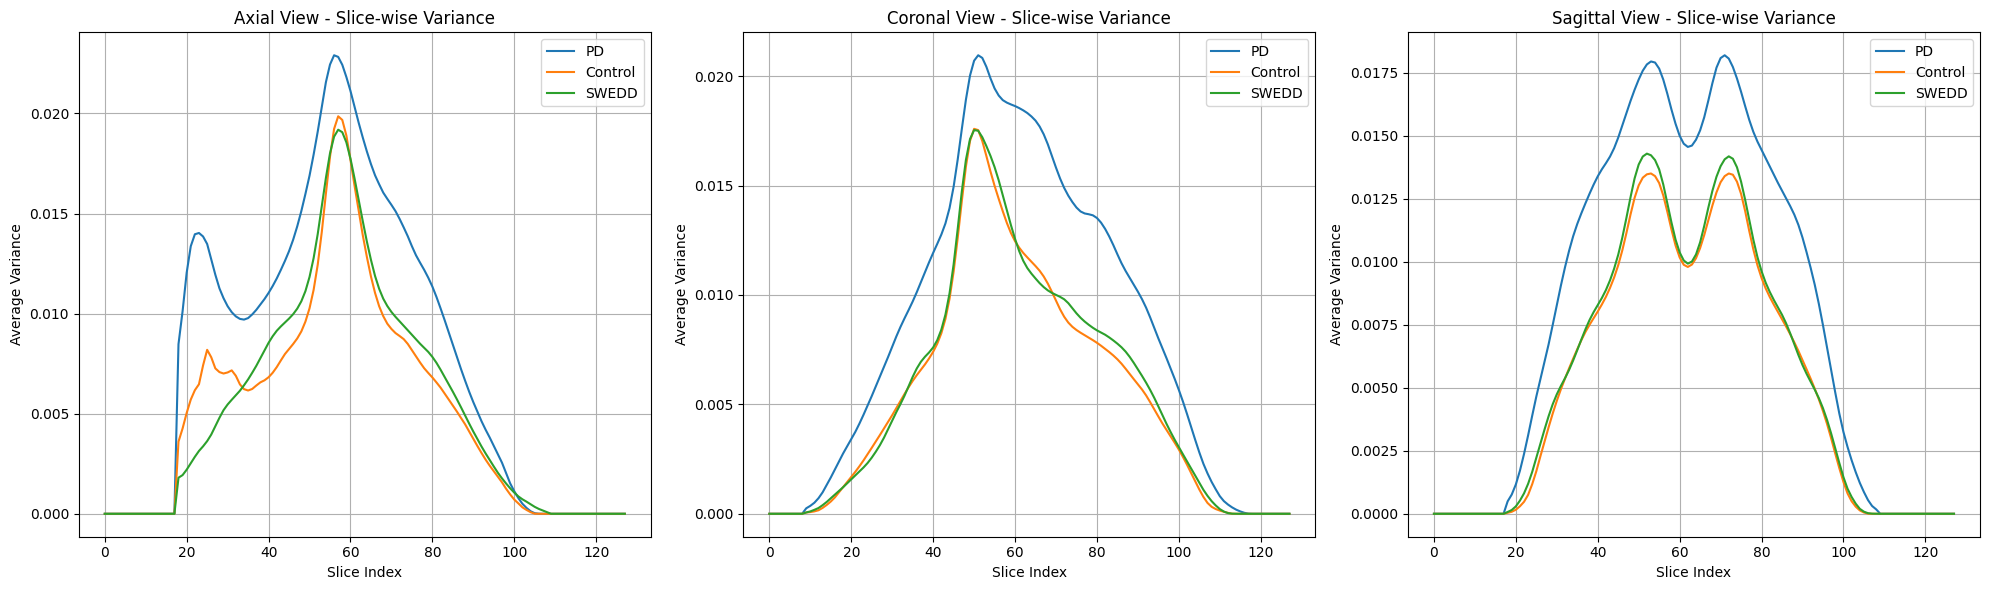

In [14]:
# Analyze slice-wise variance
print("\nAnalyzing slice-wise variance patterns...")
avg_variances = analyze_slice_variance(train_loader, num_samples_per_group=5)

if avg_variances is not None:
    print("\nPlotting slice-wise variance analysis...")
    plot_slice_variances(avg_variances)